# Project 1 - SME808
* Leonardo Meireles - NUSP: 4182085
* Antonio Moreira - NUSP: 9779242

## Objective
* Basic time series analysis:
    * Trend
    * Seasonality
    * Outliers
    * Structural Changes

## Properties and types of series

* **Trend** : A long-term increase or decrease in the data. This can be seen as a slope (is doesn’t have to be linear) roughly going through the data.

* **Seasonality** : A time series is said to be seasonal when it is affected by seasonal factors (hour of day, week, month, year, etc.). Seasonality can be observed with nice cyclical patterns of fixed frequency.

* **Cyclicity** : A cycle occurs when the data exhibits rises and falls that are not of a fixed frequency. These fluctuations are usually due to economic conditions, and are often related to the “business cycle”. The duration of these fluctuations is usually at least 2 years.

* **Residuals** : Each time series can be decomposed in two parts:
    - A forecast, made up of one or several forecasted values
    - Residuals. They are the difference between an observation and its predicted value at each time step. 
    
Remember that: **Value of series at time t = Predicted value at time t + Residual at time t**  =: **TS(t) = P(t) + R(t)**

In [341]:
# Librarys used - All Open Source
# settings
import warnings
warnings.filterwarnings("ignore")

# Basic packages
import re
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd  # generating random numbers
import datetime  # manipulating date formats
# Viz
import matplotlib.pyplot as plt  # basic plotting
import seaborn as sns  # for prettier plots
import matplotlib.style as style
style.use('ggplot')
import handcalcs.render


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf, arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.stats import truncnorm

In [110]:
def parse_co2_data(filename, columns_start_point=0):
    """
        Function that parses the NOA CO2 data to
        a more compatible format with pandas.
    """
    
    with open(filename) as f:
        file = f.readlines()[columns_start_point:]
    
    columns = re.sub(u'\s+|,,\s+', ' ', file[0]).strip().split(' ')
    df = pd.DataFrame(columns=columns)
    
    for i in range(1, len(file)):
        series = re.sub(u'\s+|,,\s+', ' ', file[i]).strip().split(' ')
        df = df.append(pd.Series(data=series, index=columns), ignore_index=True)
    
    filename = filename.replace('.csv', '_parsed.csv')
    df.to_csv(filename, index=False)    
    
    df = pd.read_csv(filename, low_memory=False)
    
    return df

## NOA CO2: Monthly CO2 Series
* Using the monthly CO2 emission time series, we are going to analyze it to find trends, seasonality, outliers and structural changes.

## Preprocessing
* The only processing we had to do was to use the interpolated value of the CO2 emission where the data was missing.
* There were no signficant outliers in the time series.

In [111]:
df_co2_mm_mlo = parse_co2_data('../data/co2_mm_mlo.csv', columns_start_point=70)
# Fill missing data with interpolated data
df_co2_mm_mlo.loc[df_co2_mm_mlo.average <= -99.99, 'average'] = df_co2_mm_mlo.loc[df_co2_mm_mlo.average <= -99.99, 'interpolated']

## Trend Analysis
* Plotting the time series and it's annual moving average and std we can try to find some kind o trend in the time series.

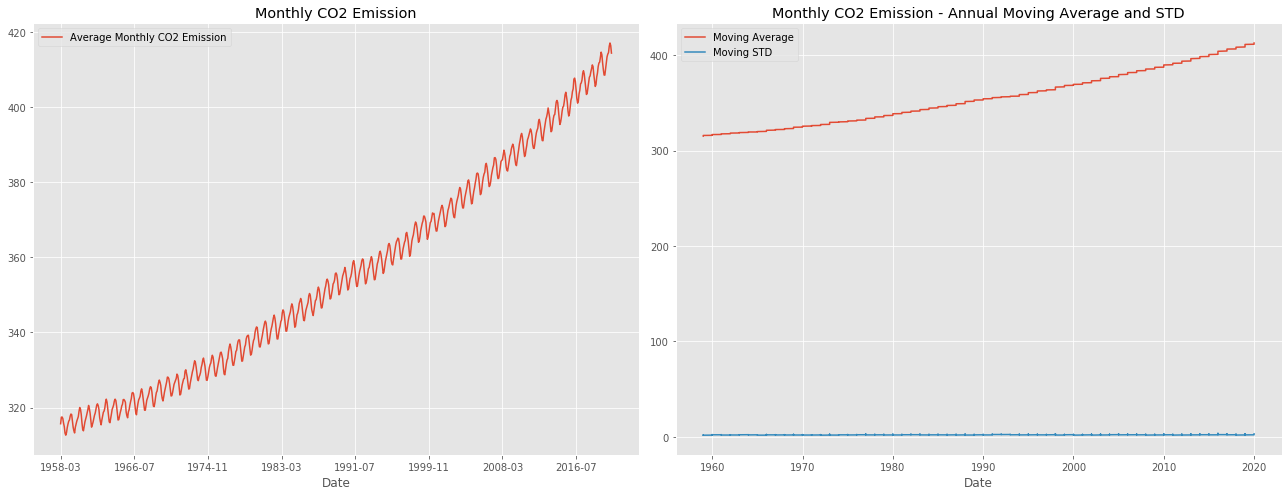

In [112]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Monthly time series
df_co2_mm_mlo['date'] = df_co2_mm_mlo['year'].map(str) + '-' + df_co2_mm_mlo['month'].map(str)
df_co2_mm_mlo['date'] = pd.to_datetime(df_co2_mm_mlo['date'], format='%Y-%m').dt.strftime('%Y-%m')

df_co2_mm_mlo.plot(x='date', y='average', ax=ax1, label='Average Monthly CO2 Emission')

# Annual moving averages period = 12 months
ax2.plot(df_co2_mm_mlo['year'],df_co2_mm_mlo['average'].rolling(window=12, center=False).mean(), label='Moving Average')
ax2.plot(df_co2_mm_mlo['year'], df_co2_mm_mlo['average'].rolling(window=12, center=False).std(), label='Moving STD')

ax1.set_title('Monthly CO2 Emission')
ax1.set(xlabel = 'Date')

ax2.set_title('Monthly CO2 Emission - Annual Moving Average and STD')
ax2.set(xlabel = 'Date')

plt.tight_layout()
plt.legend()

## Quick Observations

Looking at the moving average plot we can notice a trend that increases each year due to human advances in technology(cars, agriculture, planes) and no noticible seasonality. Also, we didn't notice any structural changes in the time series.

## Google Shares
* We are going to run the same analysis but in the time series that represents google shares from 2006 to 2018.
* Daily data containing information about Open, High, Low, Close and Volume.
* Our variable of interest in the close price:
    * A stock's closing price is the standard benchmark used by investors to track its performance over time.
    * The closing price is the last price at which the stock traded during the regular trading day.

In [113]:
# Reading the data
google = pd.read_csv(filepath_or_buffer='../data/GOOGLE_2006-01-01_to_2018-01-01.csv')

In [114]:
google.Date = pd.to_datetime(google.Date)

In [115]:
google.index = google.Date

In [116]:
# Calculating the annual moving averages and std so we and don't have to compute it everytime
annual_close_mmean = google['Close'].rolling('365D', center=False).mean()

In [117]:
annual_close_mstd = google['Close'].rolling('365D', center=False).std()

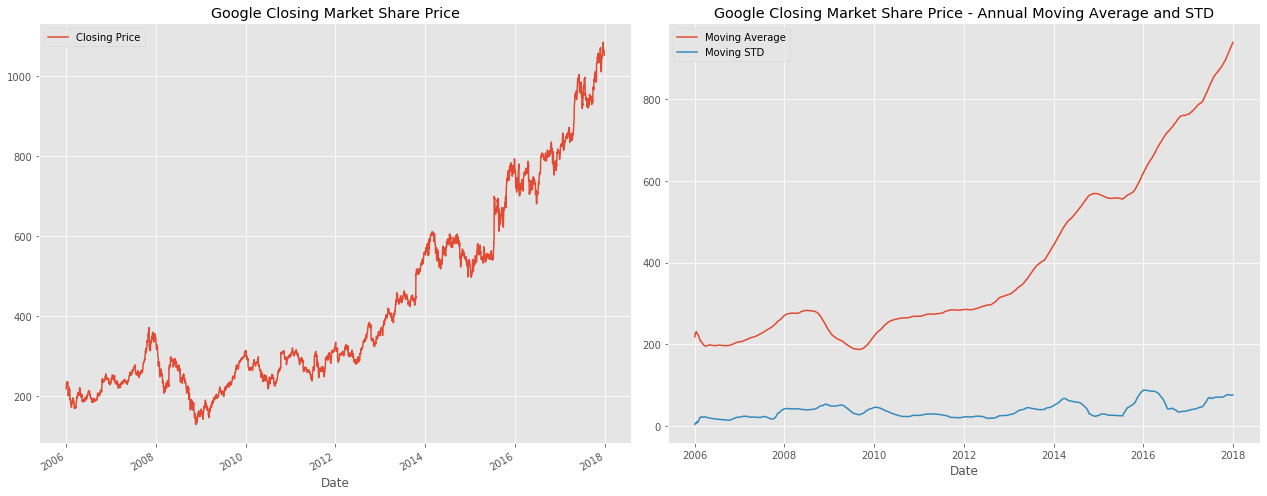

In [118]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

google.plot(x='Date', y='Close', ax=ax1, label='Closing Price')

# Annual moving averages period = 12 months
ax2.plot(google['Date'], annual_close_mmean, label='Moving Average')
ax2.plot(google['Date'], annual_close_mstd, label='Moving STD')

ax1.set_title('Google Closing Market Share Price')
ax1.set(xlabel = 'Date')

ax2.set_title('Google Closing Market Share Price - Annual Moving Average and STD')
ax2.set(xlabel = 'Date')

plt.tight_layout()
plt.legend()

## Quick Observations
Looking at the moving average plot we can notice a trend and maybe a possible seasonality, we are going to use a additive version of a seasonal decomposition using stats model **sm** module, which tries to decompose a time series in three main components Trend, Seasonality and the Residual using moving averages.

$$y = \text{Trend}+\text{Seasonality}+\text{Residual}$$

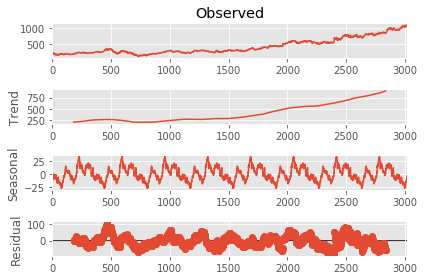

In [119]:
# Multiplicative
y = sm.tsa.seasonal_decompose(
    google['Close'].values, freq=365, model='additive')

fig = y.plot()

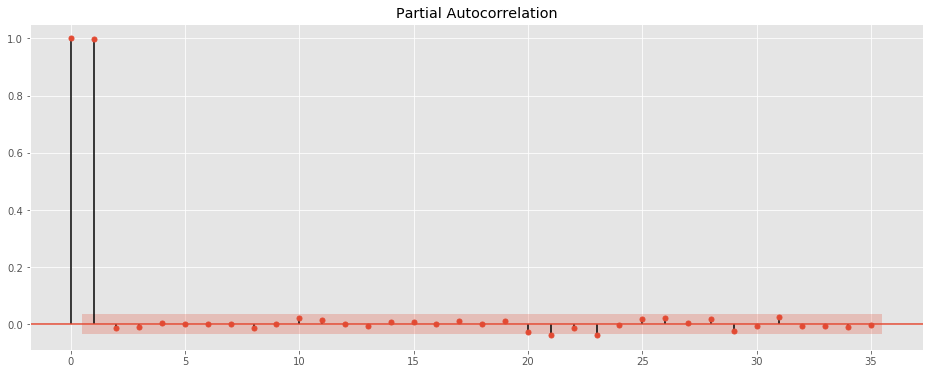

In [198]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
plot_pacf(google['Close'], ax=ax)
plt.show()

## Final Observations on Google Dataset
* We observed trend that inscreases over the time and also and slight seasonality between months.

## Exercise 2
---

In this exercise we want to analyze the behavior of the **Ibovespa** daily market close time series, from January of 2005 to August of 2020. The dataset was extracted from this [link](http://www.ipeadata.gov.br/).

At the first moment, on the preprocessing step, the dataset was sliced to belong to the appropriate time period, then we fill missing values with an linear interpolation. 

The organization of this dataset after preprocessing step is:

$$ observation_i = (date_i, close_i) \;\; \forall i \in (0,5726)$$

$$ o_i = (d_i, c_i) \;\; \forall i \in (0,5726)$$
    
 - $date_i$ is the ith date of the ith $close_i$ value of ibovespa.

### Reading and preprocessing dataset

In [61]:
ibov_data = pd.read_excel("../data/ipeadata[05-09-2020-06-33].xls")
ibov_data.head()

,Date,Close
0,04/07/1994,3580.8
1,05/07/1994,3564.3
2,06/07/1994,3753.5
3,07/07/1994,3904.9
4,08/07/1994,4051.9


In [62]:
ibov_data.Date = pd.to_datetime(ibov_data.Date)

In [63]:
ibov_data.index = ibov_data.Date
ibov_data = ibov_data.sort_index()

In [64]:
ibov_data.head()

,Date,Close
Date,,
1994-01-08,1994-01-08,4152.0
1994-01-09,1994-01-09,5436.9
1994-01-10,1994-01-10,NaN
1994-01-11,1994-01-11,4700.8
1994-01-12,1994-01-12,4652.3


### Only dates > 2005

In [65]:
ibov_data = ibov_data.loc[ibov_data['Date'] >= '2005-01-01'].copy()
ibov_data.head()

,Date,Close
Date,,
2005-01-01,2005-01-01,NaN
2005-01-02,2005-01-02,24149.0
2005-01-03,2005-01-03,27729.0
2005-01-04,2005-01-04,26773.0
2005-01-05,2005-01-05,NaN


### Fill NaN Values - Linear Interpolation

Given two known points $p_1=(x_0, y_0)$ and $p_2=(x_1, y_1)$, the **linear interpolation** is the straight line between this two points.

$$\frac{y-y_0}{x-x_0} = \frac{y_1-y_0}{x_1-x_0} $$

$$y=\frac{y_0(x_1-x)+y_1(x-x_0)}{x_1-x_0} $$ 

The above equation is the equation of the straight line generated by those two points. Any point between $(x_0, x_1)$ belongs to the linear interpolation, points outside this interval belong to the **linear extrapolation**.

So, given two points $o_0=(d_0, c_0)$ and $o_2=(d_2, c_2)$, where all coordinates are known and one point $o_1=(d_1, c_1)$ where $c_1$ coordinates are unknown, but $d_1 \in (d_0,d_2)$. We estimate $c_1$ value by straight line equation between $o_1$ and $o_2$.

In [66]:
ibov_data.loc[ibov_data.isnull().any(axis=1)]

,Date,Close
Date,,
2005-01-01,2005-01-01,NaN
2005-01-05,2005-01-05,NaN
2005-01-10,2005-01-10,NaN
2005-01-15,2005-01-15,NaN
2005-01-16,2005-01-16,NaN
...,...,...
2020-11-06,2020-11-06,NaN
2020-11-07,2020-11-07,NaN
2020-12-01,2020-12-01,NaN


In [67]:
ibov_data['Close'] = ibov_data['Close'].interpolate(method='linear')

In [68]:
ibov_data = ibov_data.loc[~ibov_data.isnull().any(axis=1)]

In [69]:
ibov_data.head()

,Date,Close
Date,,
2005-01-02,2005-01-02,24149.0
2005-01-03,2005-01-03,27729.0
2005-01-04,2005-01-04,26773.0
2005-01-05,2005-01-05,26360.5
2005-01-06,2005-01-06,25948.0


In [70]:
ibov_data.shape

(5725, 2)

### Time-series analysis

From the plot below we notice that the time series:

1. Isn't stationary;
2. Has an positive trend over time;
3. Maybe has an monthly seasonality. 

In [71]:
annual_close_mmean = ibov_data['Close'].rolling('30D', center=False).mean()
annual_close_mstd = ibov_data['Close'].rolling('30D', center=False).std()

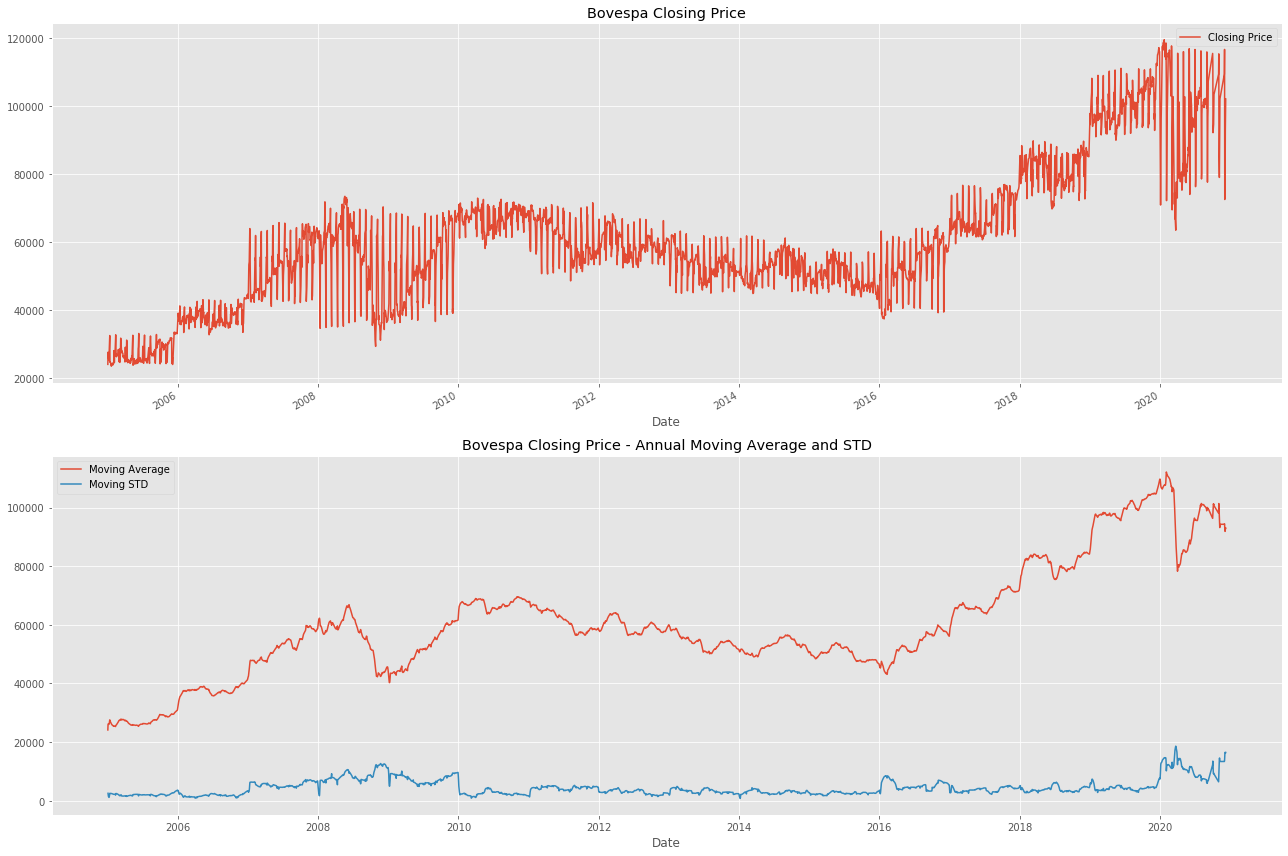

In [72]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12))

ibov_data.plot(x='Date', y='Close', ax=ax1, label='Closing Price')

# Annual moving averages period = 30 days
ax2.plot(ibov_data['Date'], annual_close_mmean, label='Moving Average')
ax2.plot(ibov_data['Date'], annual_close_mstd, label='Moving STD')

ax1.set_title('Bovespa Closing Price')
ax1.set(xlabel = 'Date')

ax2.set_title('Bovespa Closing Price - Annual Moving Average and STD')
ax2.set(xlabel = 'Date')

plt.tight_layout()
plt.legend()

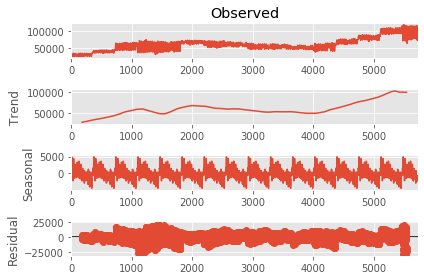

In [107]:
# Multiplicative
y = sm.tsa.seasonal_decompose(
    ibov_data['Close'].values, freq=365, model='additive')

fig = y.plot()

### LOG Return & Autocorrelation
---
We denote the close price on t instant as $C_t$, so:

$$R_t = \frac{C_t - C_{t-1}}{C_{t-1}} = \frac{C_t}{C_{t-1}}-1 $$

Applying the *log-return* we remove the trend of the time series, so we can see on the graph below the daily return price shows a huge volatility, which means that the closing price can change dramatically over a short period of time.    

By the autocorrelation and partial autocorrelation graph, we can infer that maybe there is a monthly seasonality and that is shown by high values of the correlation on those lags/periods (30 days).  

In [75]:
ibov_data['Daily_Return'] = ibov_data['Close']/ibov_data['Close'].shift(1) # one day back

In [76]:
ibov_data['Daily_Return_pct'] = ibov_data['Close'].pct_change(1)

In [77]:
ibov_data['Daily_Return_log'] = np.log(ibov_data['Daily_Return'])

In [79]:
ibov_data.head()

,Date,Close,Daily_Return,Daily_Return_pct,Daily_Return_log
Date,,,,,
2005-01-02,2005-01-02,24149.0,NaN,NaN,NaN
2005-01-03,2005-01-03,27729.0,1.148246,0.148246,0.138236
2005-01-04,2005-01-04,26773.0,0.965523,-0.034477,-0.035085
2005-01-05,2005-01-05,26360.5,0.984593,-0.015407,-0.015527
2005-01-06,2005-01-06,25948.0,0.984352,-0.015648,-0.015772


In [80]:
#ibov_data.plot(x='Date', y='Close_shift_one', label='Closing Price', figsize=(20,10))

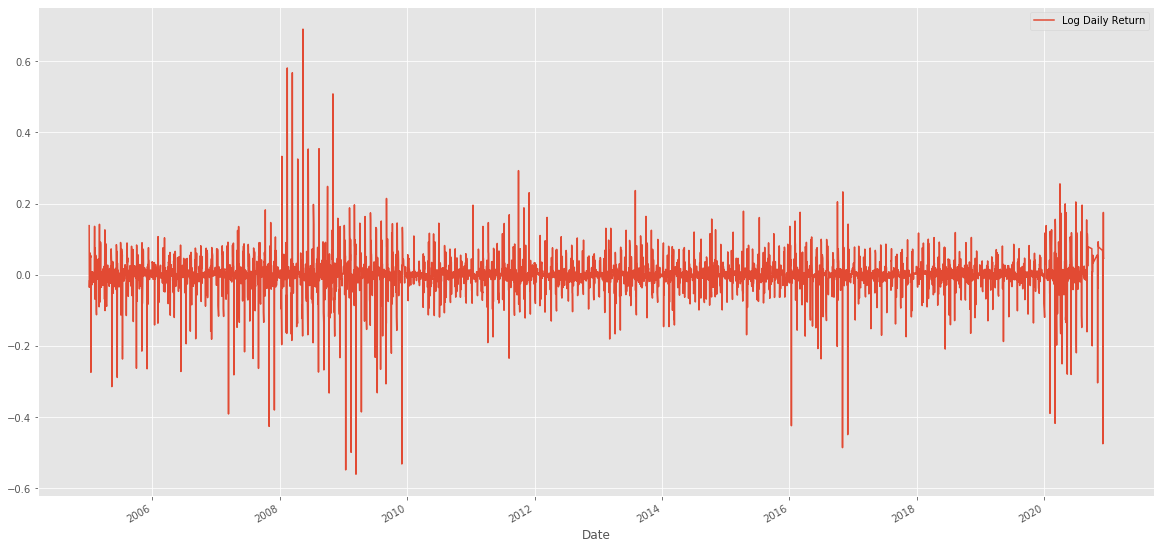

In [391]:
ibov_data.plot(x='Date', y='Daily_Return_log', label='Log Daily Return', figsize=(20,10))

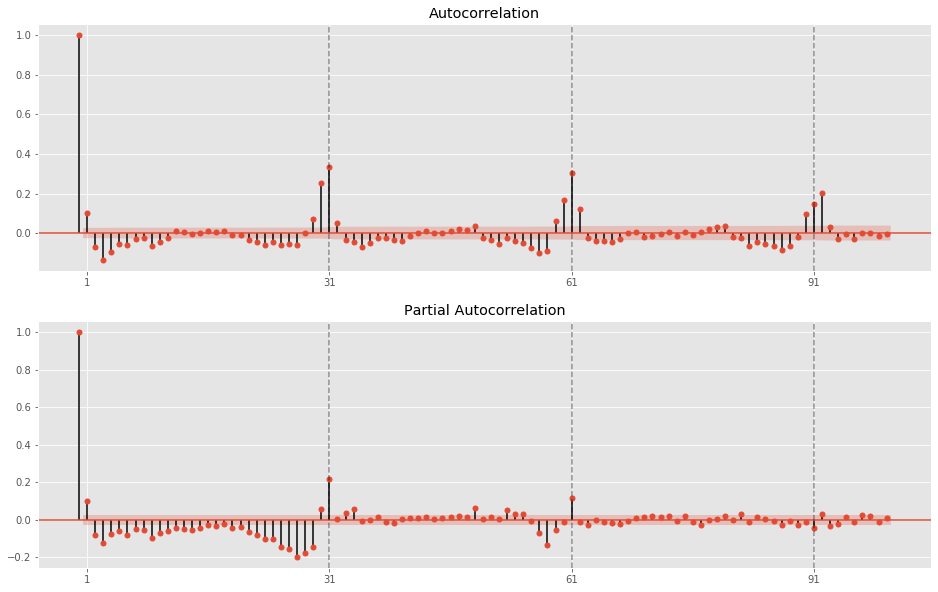

In [121]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
plot_acf(ibov_data['Daily_Return_log'].iloc[1:], lags=100, ax=ax1)

plot_pacf(ibov_data['Daily_Return_log'].iloc[1:], lags=100, ax=ax2)

for i in range(31,92,30):
    ax1.axvline(i,color='k', linestyle='--', alpha=0.4)
    ax2.axvline(i,color='k', linestyle='--', alpha=0.4)
    
ax1.set_xticks(list(range(1,92,30)))
ax2.set_xticks(list(range(1,92,30)))

    
plt.show()

# Log-return histogram

In this session we propose to analyze the behavior of the daily log returns distribution, as we can see most of the values are nearest $0$. 

The spread metrics kurtosis and skewness were used to calculate "*peakedness*" and asymmetry of the distribution, respectively.

|Kurtosis|Skewness|
|----|----|
|$26.0667$|$-0.881$|

- By the skewness value we can notice that the symmetry of the distribution have tendency to the right side.
- By the kurtosis value we can notice that the distribution is thin and the values are centered around the mean, and that causes the tail to be heavier compared to a normal distribution (blue curve on the graph).  


In [343]:
min_dlog = ibov_data['Daily_Return_log'].min()
max_dlog = ibov_data['Daily_Return_log'].max()
mean_dlog  = ibov_data['Daily_Return_log'].mean()
std_dlog  = ibov_data['Daily_Return_log'].std()

In [359]:
skew_dlog = ibov_data['Daily_Return_log'].skew()
kurtosis_dlog = ibov_data['Daily_Return_log'].kurtosis()

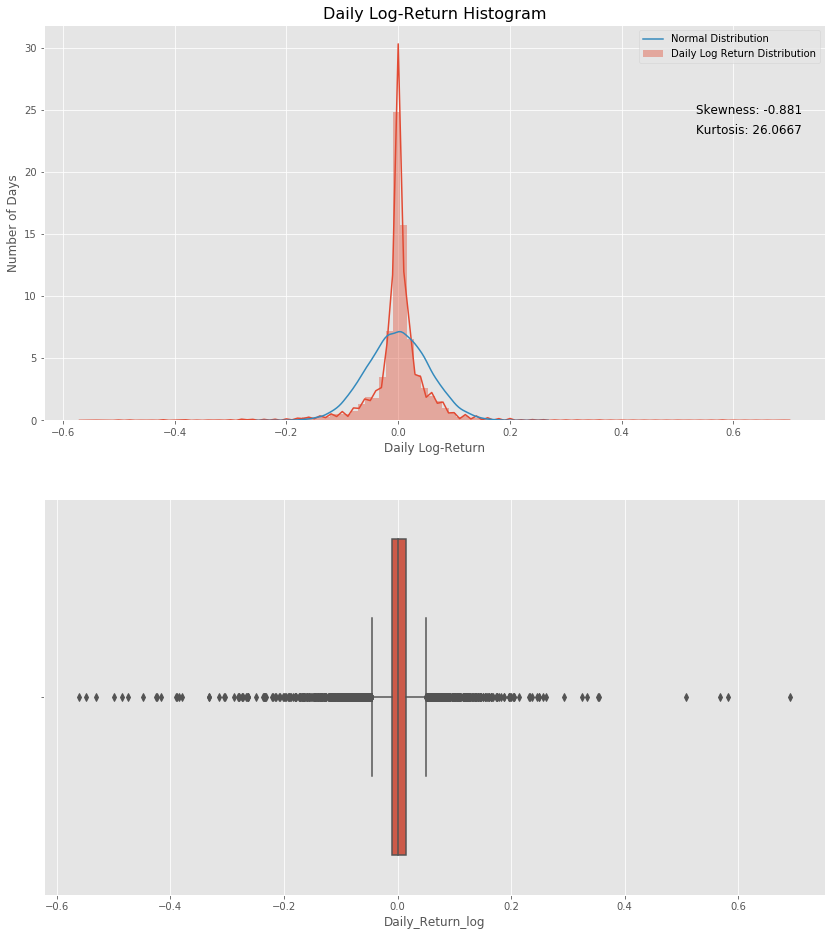

In [384]:
fig,(ax1,ax2)= plt.subplots(2, 1, figsize=(14, 16))
sns.distplot(ibov_data['Daily_Return_log'], bins=100, ax=ax1, label='Daily Log Return Distribution')
ax1.set_title("Daily Log-Return Histogram", fontsize=16)
ax1.set_xlabel("Daily Log-Return")
sns.distplot(np.random.normal(mean_dlog, std_dlog, 50000), hist=False, ax=ax1, label='Normal Distribution')

ax1.text(x=0.97, y=0.8, transform=ax1.transAxes, s="Skewness: {skew}".format(skew=round(skew_dlog,4)),
        fontsize=12, verticalalignment='top', horizontalalignment='right')

ax1.text(x=0.97, y=0.75, transform=ax1.transAxes, s="Kurtosis: {skew}".format(skew=round(kurtosis_dlog,4)),
        fontsize=12, verticalalignment='top', horizontalalignment='right')


sns.boxplot(ibov_data['Daily_Return_log'], ax=ax2)


ax1.set_ylabel("Number of Days")
plt.show()

# Squared Daily Log-Return

Squaring the daily log-return eases the calculation of arrive at a deviation measure, becoming easier the visualization of volatility. Here, the correlation of lags/periods of 30 days can be noticed as well. 

In [387]:
ibov_data['Sq_Daily_Return_log'] = pow(ibov_data['Daily_Return_log'],2)

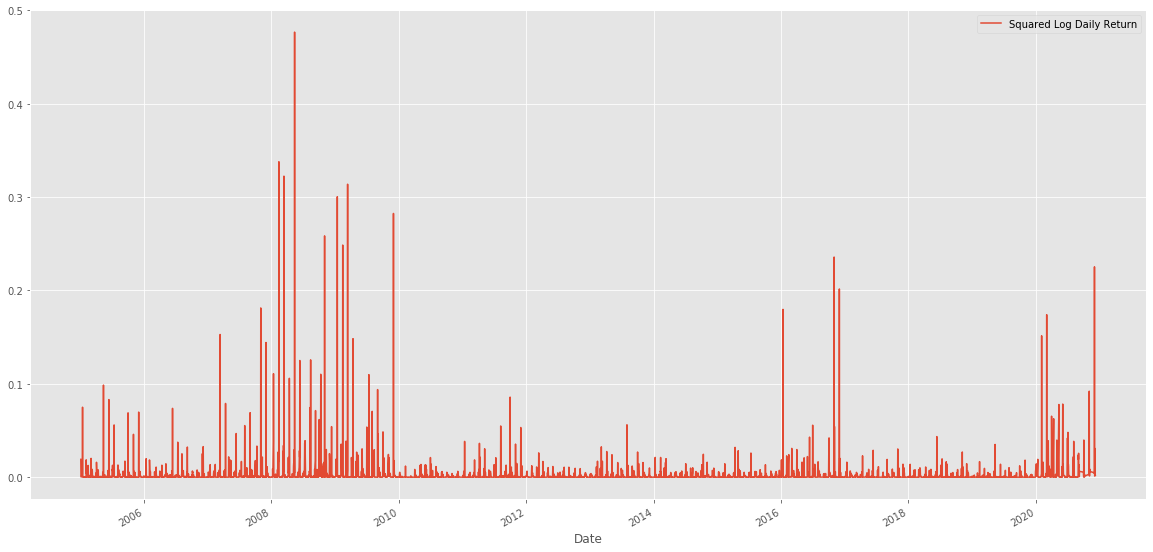

In [390]:
ibov_data.plot(x='Date', y='Sq_Daily_Return_log', label='Squared Log Daily Return', figsize=(20,10))

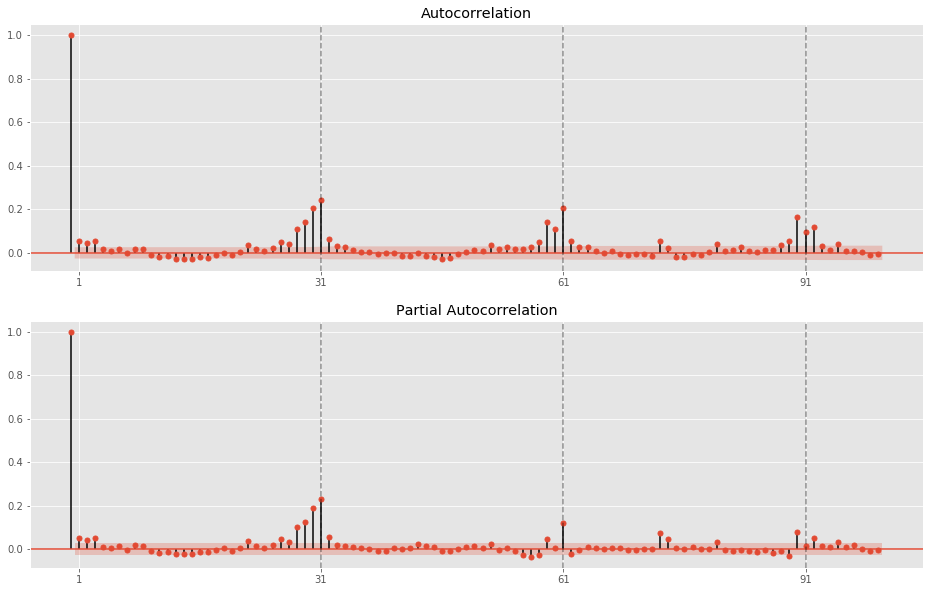

In [388]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
plot_acf(ibov_data['Sq_Daily_Return_log'].iloc[1:], lags=100, ax=ax1)

plot_pacf(ibov_data['Sq_Daily_Return_log'].iloc[1:], lags=100, ax=ax2)

for i in range(31,92,30):
    ax1.axvline(i,color='k', linestyle='--', alpha=0.4)
    ax2.axvline(i,color='k', linestyle='--', alpha=0.4)
    
ax1.set_xticks(list(range(1,92,30)))
ax2.set_xticks(list(range(1,92,30)))

    
plt.show()